# Comparison of Career Topic Switching from three different Databases

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pylab as plt

import pyscisci.all as pyscisci

try:
    import seaborn as sns
    sns.set_style('white')
    
    from cdlib import algorithms
    
    from clusim.clustering import Clustering
except:
    print('This example requires the optional packages seaborn, cdlib and clusim.')
    print('Please run:')
    print('pip install seaborn cdlib clusim')

Setup the three databases

In [2]:
# set this path to where the APS database is stored
path2aps = '/home/ajgates/APS'
path2aps = '/Volumes/GatesExpansionDrive/DataSets/APS/APS2019'

myaps = pyscisci.APS(path2aps, keep_in_memory=False) 

# override the default APS data with the author disambiguation
myaps.set_new_data_path('paa', 'publicationauthoraffiliation_supp2010')

In [3]:
# set this path to where the MAG database is stored
path2mag = '/home/ajgates/MAG'
path2mag = '/Volumes/GatesExpansionDrive/DataSets/MAG'

mymag = pyscisci.MAG(path2mag, show_progress=True) 

In [4]:
# set this path to where the MAG database is stored
path2wos = '/home/ajgates/WOS'

mywos = pyscisci.WOS(path2wos, show_progress=True) 

In [5]:
# we pick a prominent physics author to study

mag_author_id = 2420755856
aps_author_id = 81060
wos_author_id = 605000

three_databases = [('APS', myaps, aps_author_id), ('MAG', mymag, mag_author_id)] #,('WOS', mywos, wos_author_id)]

In [6]:
author_networks = []

for dbname, database, author_id in three_databases:
    
    # we load the publication-author relationships the same way from each database
    author_filter_dict = {'AuthorId':np.sort([author_id])}
    author_paa = database.load_publicationauthoraffiliation(columns=['PublicationId', 'AuthorId'],
                                                            filter_dict=author_filter_dict, 
                                                            duplicate_subset=['PublicationId', 'AuthorId'])
    
    # because the aps author info is only until 2010, we standardize across all three databases
    pub2year = database.pub2year
    author_paa['Year'] = [pub2year.get(pid, None) for pid in author_paa['PublicationId'].values]
    author_paa = author_paa[author_paa['Year'] <= 2010]
    
    # now load the publication to reference linkages only for the authors publications
    pub_filter_dict = {'CitingPublicationId':np.sort(author_paa['PublicationId'].unique())}
    pub2ref = database.load_references(columns=['CitingPublicationId', 'CitedPublicationId'],
                                                            filter_dict=pub_filter_dict)
    
    career_topics, cocite_network = pyscisci.career_cociting_network_topics(author_paa, 
                                                                        pub2ref, 
                                        randomize=42, 
                                        return_network=True, show_progress=False)
    author_networks.append([dbname, career_topics, cocite_network])
    print(dbname + ':', nx.info(cocite_network))
    
author_paa = pd.read_hdf('/Users/ajgates/Desktop/wos_paa_stanley.hdf')    
pub2ref = pd.read_hdf('/Users/ajgates/Desktop/wos_ref_stanley.hdf')

author_paa = author_paa[author_paa['PubYear'] <= 2010]
author_paa = author_paa.rename(columns={'ArticleID':'PublicationId', 'PubYear':'Year', 
                                        'AuthorDAIS': 'AuthorId'})
pub2ref = pub2ref.rename(columns={'CitingArticleID':'CitingPublicationId', 
                                  'CitedArticleID':'CitedPublicationId'})

career_topics, cocite_network = pyscisci.career_cociting_network_topics(author_paa, 
                                                                        pub2ref, 
                                        randomize=42, 
                                        return_network=True, show_progress=False)
author_networks.append(['WOS', career_topics, cocite_network])
print('WOS' + ':', nx.info(cocite_network))

Loading Publication Author Affiliation:   0%|          | 0/1 [00:00<?, ?it/s]

Loading pub2ref:   0%|          | 0/1 [00:00<?, ?it/s]

APS: Graph with 302 nodes and 2955 edges


Loading Publication Author Affiliation:   0%|          | 0/63 [00:00<?, ?it/s]

Loading pub2ref:   0%|          | 0/160 [00:00<?, ?it/s]

MAG: Graph with 452 nodes and 10440 edges
WOS: Graph with 881 nodes and 37224 edges


In [29]:
afiles = [fname for fname in os.listdir('/Volumes/GatesExpansionDrive/DataSets/WOSold/author/') if '.hdf' in fname]
allauthors = []
for fname in afiles:
    allauthors.append(pd.read_hdf('/Volumes/GatesExpansionDrive/DataSets/WOSold/author/' + fname).dropna(subset=['AuthorDAIS']))

allauthors = pd.concat(allauthors)
print(allauthors.shape)

(102007395, 7)


In [38]:
afiles = [fname for fname in os.listdir('/Volumes/GatesExpansionDrive/DataSets/WOSold/article/') if '.hdf' in fname]
allpubs = []
for fname in afiles:
    pdf = pd.read_hdf('/Volumes/GatesExpansionDrive/DataSets/WOSold/article/' + fname)
    allpubs.append(pdf[pyscisci.isin_sorted(pdf['ArticleID'].values, np.sort(wos_paa['ArticleID'].unique()))])
allpubs = pd.concat(allpubs)
print(allpubs.shape)

wos_paa= allauthors[allauthors['AuthorDAIS']==605000.0].reset_index(drop=True)
wos_paa = wos_paa.merge(allpubs, how='left', on='ArticleID')
wos_paa.to_hdf('/Users/ajgates/Desktop/wos_paa_stanley.hdf', key='paa', mode='w')

(1044, 22)


In [42]:
afiles = [fname for fname in os.listdir('/Volumes/GatesExpansionDrive/DataSets/WOSold/citation/') if '.hdf' in fname]
allrefs = []
for fname in afiles:
    cdf = pd.read_hdf('/Volumes/GatesExpansionDrive/DataSets/WOSold/citation/' + fname)
    allrefs.append(cdf[pyscisci.isin_sorted(cdf['CitingArticleID'].values, np.sort(wos_paa['ArticleID'].unique()))])
allrefs = pd.concat(allrefs)
print(allrefs.shape)

allrefs.to_hdf('/Users/ajgates/Desktop/wos_ref_stanley.hdf', key='ref', mode='w')

(38302, 2)


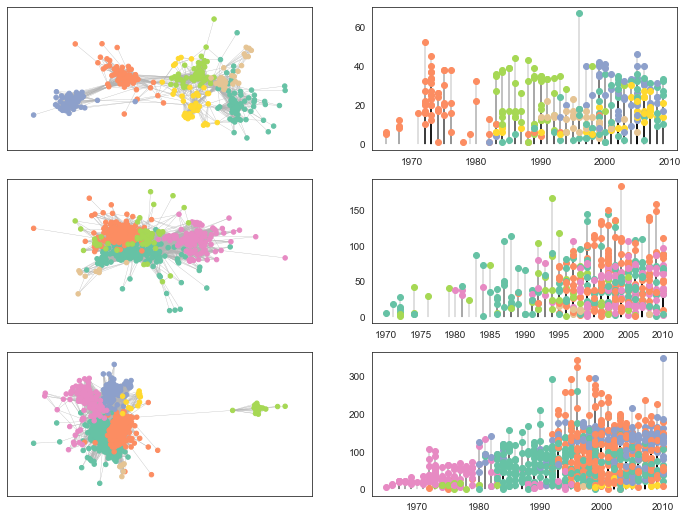

In [8]:
fig, ax = plt.subplots(3,2, figsize=(12, 9))

cmap = sns.color_palette("Set2", as_cmap=True)

for iax in range(3):

    dbname, career_topics, cocite_network = author_networks[iax]
    
    pos = nx.drawing.nx_agraph.graphviz_layout(cocite_network, prog='sfdp',)
  

    nx.draw_networkx_edges(cocite_network, pos, edgelist=cocite_network.edges(),
            edge_color = '0.7', width=0.3,
            ax=ax[iax,0])
    
    topic_community = nx.get_node_attributes(cocite_network, 'TopicCommunity')

    louvain_communities = Clustering().from_membership_list([topic_community[i] for i in range(len(topic_community))])

    for c in louvain_communities.clusters:
        nx.draw_networkx_nodes(cocite_network.subgraph(louvain_communities.clu2elm_dict[c]), pos,
            node_size= 20, 
            node_color=[c]*len(louvain_communities.clu2elm_dict[c]),
            cmap = cmap,
            #edgecolors='0.2', # node outline
            linewidths = None,
            vmin = 0,
            vmax = louvain_communities.n_clusters,
            label = str(c),
            ax = ax[iax,0])

    
    
    for y, topic, degree in career_topics[['Year', 'TopicCommunity', 'Degree']].values:
        ax[iax,1].scatter(y, degree, c=[topic], cmap=cmap, vmin=0,
                   vmax=louvain_communities.n_clusters, zorder=5)
        ax[iax,1].plot([y,y], [0,degree], color='k', lw=0.25, zorder=4)

plt.savefig('DatabaseCompareTopicSwitching.pdf')
plt.show()
